In [59]:
import pickle
import matplotlib.pyplot as plt
import os
import glob
import math
import numpy as np
import astropy.units as u

%matplotlib inline

# Loading Files

In [171]:
## The run from 0723
#targets = pickle.load(open('/Users/ramini/Documents/HabEx/py/drms/0723/targetList/targetList.pkl'))
#path = '/Users/ramini/Documents/HabEx/py/drms/0723/'

# Architecture A - 10/9/18
targets = pickle.load(open('/Users/ramini/Documents/HabEx/py/drms/1017A/targetList/targetList.pkl'))
path = '/Users/ramini/Documents/HabEx/py/drms/1017A/'

data = []
for filename in glob.glob(os.path.join(path, '*.pkl')):
    temp = pickle.load(open(filename))
    # print len(temp)
    if len(temp) > 500:
        data.append(temp)

In [172]:
len(data)

46

# Defining Constants

In [83]:
mission_life = 5 * u.year
exo_sci_compression_factor = 0.75
compression_factor = 0.75
sec_week = 3600 * 24 * 7 * u.s

det_b_depth = 12 # b/px
char_b_depth = 12 # b/px

det_int_time = 100 * u.s
char_int_time = 300 * u.s

# Detection is done with the coronograph camera(s)
# Coronograph A & B are used simultaneously. 
# Coronograph A:
#       Blue IFS:    2048 x 2048 px, 0% utilization, 12 bits/channel
#       Blue Camera: 1024 x 1024 px, 95% utilization, 12 bits/channel
#       Blue LOFWS:  1024 x 1024 px, 5% utilization, 12 bits/channel

c_a_blue_ifs = [2048, 0.0, det_b_depth] 
c_a_blue_cam_px = [1024, 0.95, det_b_depth]
c_a_blue_lowfs_px = [1024, 0.0, det_b_depth] # We say 0 util because of data calc.

coronograph_A = [c_a_blue_ifs, c_a_blue_cam_px, c_a_blue_lowfs_px]

# Coronograph B:
#       Red IFS:    2048 x 2048 px, 0% utilization, 12 bits/channel
#       Red Camera: 1024 x 1024 px, 47.5% utilization, 12 bits/channel
#       Red LOFWS:  1024 x 1024 px, 5% utilization, 12 bits/channel
#       IR Camera:  256 x 256 px, 47.5% utilization, 12 bits/channel

c_b_red_ifs_px = [2048, 0.0, det_b_depth]
c_b_red_cam_px = [1024, 0.475, det_b_depth]
c_b_red_lowfs_px = [1024, 0.0, det_b_depth] # We say 0 util because of data calc.
c_b_ir_cam_px = [256, 0.475, det_b_depth]

coronograph_B = [c_b_red_ifs_px, c_b_red_cam_px, c_b_red_lowfs_px, c_b_ir_cam_px]

# Characterization is done with the starshade camera(s)
# Starshade Cameras:
#       UV Camera:  512 x 512 px, 100% util, 12 bits/channel
#       VIS IFS:    4092 x 4092 px, 100% util, 12 bits/channel
#       VIS Camera: 512 x 512 px, 0% util, 12 bits/channel
#       IR Camera:  256 x 256 px, 0% util, 12 bits/channel
#       IR IFS:  256 x 256 px, 100% util, 12 bits/channel

ss_uv_cam = [1024, 1.0, char_b_depth]
ss_vis_ifs = [4092, 1.0, char_b_depth]
ss_vis_cam = [1024, 0.0, char_b_depth]
ss_ir_ifs = [1024, 1.0, char_b_depth]
ss_ir_cam = [1024, 0.0, char_b_depth]

starshade = [ss_uv_cam, ss_vis_ifs, ss_vis_cam, ss_ir_ifs, ss_ir_cam]

# Other instruments
ga_overhead = 0.1
workhorse_data_rate = 2162 * u.kbit / u.s
uv_spectrograph_data_rate = 478 * u.kbit / u.s

# Defining Methods

In [85]:
def getPropUse(f, slew_angle):
    accel = 0.011328972 # deg/s**2
    mass_rate = 0.004176554 # kg/s
          
    dcf = f**2 / 2 + f * (1 - f)
    accel_factor = accel / (2 * slew_angle)
    slew_dur_temp = 1 / (accel_factor * dcf)
    slew_dur = math.sqrt(slew_dur_temp)
    
    hydrazine_mass = f * slew_dur * mass_rate
    
    return hydrazine_mass, slew_dur

def getExposures(obs_type, time):
    if obs_type is 'det':
        if time < det_int_time:
            return 1
        else:
            return math.ceil(time / det_int_time)
    if obs_type is 'char':
        if time < char_int_time:
            return 1
        else:
            return int(math.ceil(time / char_int_time))

def getInstrumentVol(instrument, exp):
    vol = 0
    for detector in instrument:
        vol = vol + (detector[0]**2 * detector[1] * detector[2] * exp)
    
    # np.sum([(detector[0]**2 * detector[1] * detector[2] * exposures) for detector in instrument])
    
    vol = vol * exo_sci_compression_factor
    
    return vol

def getTargetVolume(obs_type, exp):
    if obs_type is 'det':
        total_vol_A = getInstrumentVol(coronograph_A, exp)
        total_vol_B = getInstrumentVol(coronograph_B, exp)
        total_volT = total_vol_A + total_vol_B

    elif obs_type is 'char':
        total_volT = getInstrumentVol(starshade, exp)
    
    else:
        total_volT = 0
    
    total_volT = total_volT * u.bit
    total_vol = total_volT.to(u.Gbit)
    
    return total_vol 

def get_ga_vol(obs_time_workhorse, obs_time_uvs):
    obs_time_workhorse = obs_time_workhorse
    obs_time_uvs = obs_time_uvs
        
    workhorse_vol = workhorse_data_rate * obs_time_workhorse * compression_factor
    uvs_vol = uv_spectrograph_data_rate * obs_time_uvs * compression_factor
       
    ga_vol = uvs_vol + workhorse_vol
    
    ga_vol.to(u.Gbit)
    
    return ga_vol

# Big Script

In [273]:
# Thruster duty cycle
f = 0.05

# UV Cutoff galactic lattitude
l_cutoff_uv = 15 # deg

# GA Obs Time
single_ga_obs_dur = 3600 # s

# Time to dig the dark hole
t_ddh = 5./ 24 # d

# Assume that all GA targets at 16 deg from Exo slew arc
# rt == ReTarget
sa_rt = 16
pm_rt, sd_rt = getPropUse(0.05, sa_rt)
            
# Assume that all GA targets at 16 deg from Exo slew arc
sa_5 = 5
pm_5, sd_5 = getPropUse(0.05, sa_5)

# GA time margin in days
ga_tm = 1. / 24

all_slew_angles = []
all_exo_vol = []
all_ga_vol = []
all_ga_concur_vol = []
all_ga_standalone_vol = []
all_prop_use = []
all_slew_dur = []
all_det_obs_dur = []
all_char_obs_dur = []
all_ga_obs_dur = []
all_ga_concur_obs_dur = []
all_ga_standalone_obs_dur = []
all_char_star_ind = []
all_det_star_ind = []

det_scat = []

for drm in data:
    slew_angles = []
    exo_vol = []
    ga_vol = []
    prop_use = []
    slew_dur = []
    det_obs_dur = []
    char_obs_dur = []
    ga_obs_dur = []
    char_star_ind = []
    det_star_ind = []
    ga_concur_vol = []
    ga_standalone_vol = []
    ga_concur_obs_dur = []
    ga_standalone_obs_dur = []
    
    print 'new drm processing'
    
    for i in range(1, len(drm)-1):
        start_time = drm[i-1]['arrival_time']
        t1 = drm[i-1]['star_ind']
                
        # If characterization measurement with starshade camera
        if 'FA_char_SNR' in drm[i-1] or 'FA_det_status' in drm[i-1]:
            if 'FA_char_SNR' in drm[i-1]:
                obs_type = 'char'
                    
                # Extract observation duration
                obs_time = drm[i-1]['char_time'].cgs
                    
                # Save to char obs array
                char_obs_dur.append(obs_time.value)
                                       
                # Saving the target to the char target list
                char_star_ind.append(t1)
                
                flag = 'char_time'

            # If detection measurement with coronagraph
            elif 'FA_det_status' in drm[i-1]:
                obs_type = 'det'
                # Extract observation duration
                obs_time = drm[i-1]['det_time'].cgs

                # Save to det obs array
                det_obs_dur.append(obs_time.value)

                # Saving the target to the det target list
                det_star_ind.append(t1)

                # end_time = start_time + drm[i-1]['det_time'].value
                flag = 'det_time'
                
                det_scat.append([obs_time.value/3600 , targets['coords'][drm[i]['star_ind']]])
        
        # Determine number of exposures
        exposures = getExposures(obs_type, obs_time)
                    
        # Estimate data volume
        vol = getTargetVolume(obs_type, exposures)

        # Save data volume to exo science data volume list
        exo_vol.append(vol)
        
        # Determining if we can do concurrent UVS observations
        gal_lat = c2.transform_to('galactic').l.value
        
        if gal_lat >= l_cutoff_uv:
            gcv = get_ga_vol(obs_time, obs_time)
        else:
            gcv = get_ga_vol(obs_time, 0 * u.s)
        
        ga_vol.append(gcv)
        ga_obs_dur.append(obs_time)
        
        ga_concur_vol.append(gcv)       
        ga_concur_obs_dur.append(obs_time)
        
        # We  determine the slew angle
        t2 = drm[i]['star_ind']

        c1 = targets['coords'][t1]
        c2 = targets['coords'][t2]

        sa = c1.separation(c2).value
                
        # Calculating prop mass use & slew duration
        pm, sd = getPropUse(0.05, sa)
        
        # Saving prop mass use, slew duration, slew angle
        prop_use.append(pm)
        slew_dur.append(sd)
        slew_angles.append(sa)
               
        # Determining if the next observation is a coronagraph observation
        if 'FA_det_status' in drm[i] and 'det_time' in drm[i] and t1 != t2:
            # If the coronagraph observation is longer than 10s. 
            if drm[i]['det_time'].cgs.value > 10:
                t_cp = t_ddh
            else:
                t_cp = 0

        # Determining leftover time between observations
        time_1 = drm[i-1]['arrival_time'] + drm[i-1][flag].value + t_cp
        time_2 = drm[i]['arrival_time']
    
        leftover = time_2 - time_1
        
        # If there is leftover time, more than half a day, we go into GA mode
        if leftover > ga_tm:           
            # Get the number of targets we will observe
            new_leftover = leftover - (2 * sd_rt / (3600 * 24))
            n_ga_targets = math.floor((new_leftover * 24 * 3600) / single_ga_obs_dur)
            
            if n_ga_targets > 0:
                # Converting leftover to s
                leftover_s = new_leftover * 3600 * 24

                # Add two more slews, to go to and come back from proximal GA target
                for k in range(2):
                    prop_use.append(pm_rt)
                    slew_dur.append(sd_rt)
                    slew_angles.append(sa_rt)
                
                # Add (n_ga_targets - 1) slews of 5 deg to go between GA targets
                for k in range(int(n_ga_targets - 1)):
                    prop_use.append(pm_5)
                    slew_dur.append(sd_5)
                    slew_angles.append(sa_5)

                # I take the old leftover time. Subtract out slews. And then the remaining time is only GA observing time.
                new_leftover_s = (leftover_s - (n_ga_targets - 1) * sd_5) * (1 - ga_overhead) * u.s

                # Determining the data volume from this observation
                ga_obs_vol = get_ga_vol(new_leftover_s, new_leftover_s)

                # Saving GA data volume
                ga_vol.append(ga_obs_vol)
                ga_standalone_vol.append(ga_obs_vol)

                # Saving GA observation time
                ga_obs_dur.append(new_leftover_s)
                ga_standalone_obs_dur.append(new_leftover_s)

    all_slew_angles.append(slew_angles)
    all_exo_vol.append(exo_vol)
    all_ga_vol.append(ga_vol)
    all_prop_use.append(prop_use)
    all_slew_dur.append(slew_dur)
    all_det_obs_dur.append(det_obs_dur)
    all_char_obs_dur.append(char_obs_dur)
    all_ga_obs_dur.append(ga_obs_dur)
    all_char_star_ind.append(char_star_ind)
    all_det_star_ind.append(det_star_ind)
    all_ga_standalone_vol.append(ga_standalone_vol)
    all_ga_concur_vol.append(ga_concur_vol)
    all_ga_concur_obs_dur.append(ga_concur_obs_dur)
    all_ga_standalone_obs_dur.append(ga_standalone_obs_dur)

new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing
new drm processing


# Analysis

## Slews & Propellant Use

In [241]:
mean_prop_use_all_drms = [np.sum(x) for x in all_prop_use]

(array([ 2.,  1.,  4.,  2.,  3.,  3.,  6.,  6.,  3.,  0.,  4.,  4.,  2.,
         1.,  5.]),
 array([ 125.88578248,  141.48884969,  157.09191691,  172.69498412,
         188.29805134,  203.90111855,  219.50418577,  235.10725298,
         250.7103202 ,  266.31338741,  281.91645463,  297.51952184,
         313.12258906,  328.72565627,  344.32872349,  359.9317907 ]),
 <a list of 15 Patch objects>)

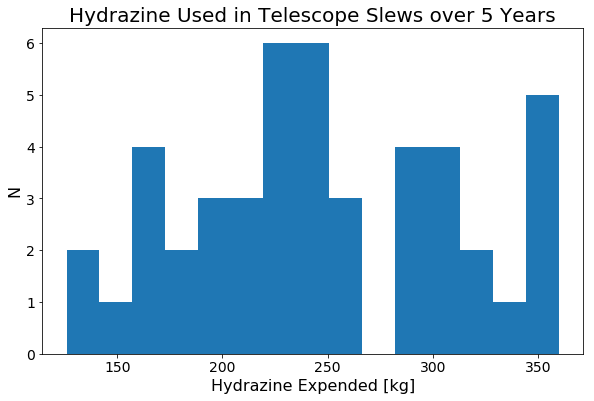

In [242]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Hydrazine Expended [kg]', fontsize=16)
plt.title('Hydrazine Used in Telescope Slews over 5 Years', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(mean_prop_use_all_drms, bins=15)

In [243]:
n_slews = [len(x) for x in all_prop_use]

(array([ 2.,  1.,  5.,  2.,  2.,  3.,  5.,  7.,  2.,  1.,  4.,  4.,  2.,
         1.,  5.]),
 array([  2413.        ,   2971.13333333,   3529.26666667,   4087.4       ,
          4645.53333333,   5203.66666667,   5761.8       ,   6319.93333333,
          6878.06666667,   7436.2       ,   7994.33333333,   8552.46666667,
          9110.6       ,   9668.73333333,  10226.86666667,  10785.        ]),
 <a list of 15 Patch objects>)

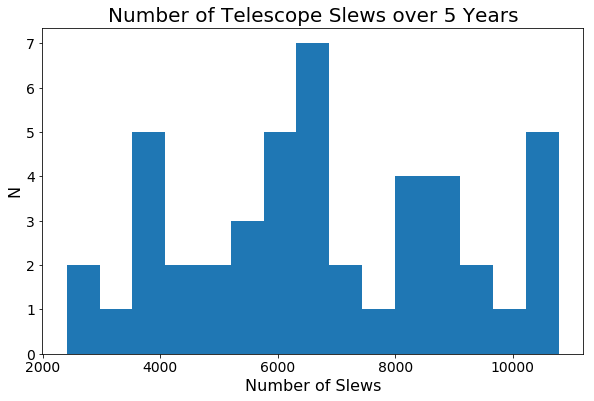

In [244]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Number of Slews', fontsize=16)
plt.title('Number of Telescope Slews over 5 Years', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(n_slews, bins=15)

In [245]:
[np.mean(n_slews), np.std(n_slews)]

[6769.782608695652, 2288.8355489489245]

In [246]:
all_slews_all_drms = [y for x in all_slew_angles for y in x]

(array([  2.73745000e+05,   5.06000000e+02,   8.97100000e+03,
          8.02000000e+02,   8.05000000e+02,   1.04500000e+03,
          1.19700000e+03,   1.02400000e+03,   1.10600000e+03,
          1.31900000e+03,   1.50900000e+03,   1.45100000e+03,
          1.33400000e+03,   1.36600000e+03,   1.52100000e+03,
          1.72600000e+03,   1.36200000e+03,   1.53200000e+03,
          1.52600000e+03,   1.09500000e+03,   1.13600000e+03,
          1.15600000e+03,   9.14000000e+02,   8.48000000e+02,
          6.43000000e+02,   5.42000000e+02,   4.43000000e+02,
          5.22000000e+02,   1.67000000e+02,   9.70000000e+01]),
 array([  5.29738990e-03,   5.98811681e+00,   1.19709362e+01,
          1.79537557e+01,   2.39365751e+01,   2.99193945e+01,
          3.59022139e+01,   4.18850334e+01,   4.78678528e+01,
          5.38506722e+01,   5.98334916e+01,   6.58163111e+01,
          7.17991305e+01,   7.77819499e+01,   8.37647693e+01,
          8.97475887e+01,   9.57304082e+01,   1.01713228e+02,
      

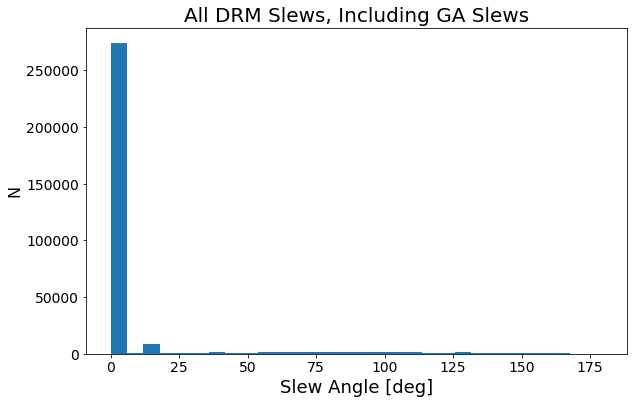

In [247]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Slew Angle [deg]', fontsize=18)
plt.title('All DRM Slews, Including GA Slews', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(all_slews_all_drms, bins=30)

In [248]:
general_astro_data_vol = [sum(x).value / 1e6 / (52 * 5) for x in all_ga_vol]

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  5.,  2.,  3.,  4.,  7.,
         4.,  2.,  4.,  5.,  2.,  2.,  3.]),
 array([ 959.08838978,  960.79928004,  962.5101703 ,  964.22106055,
         965.93195081,  967.64284106,  969.35373132,  971.06462158,
         972.77551183,  974.48640209,  976.19729235,  977.9081826 ,
         979.61907286,  981.32996311,  983.04085337,  984.75174363,
         986.46263388,  988.17352414,  989.8844144 ,  991.59530465,
         993.30619491]),
 <a list of 20 Patch objects>)

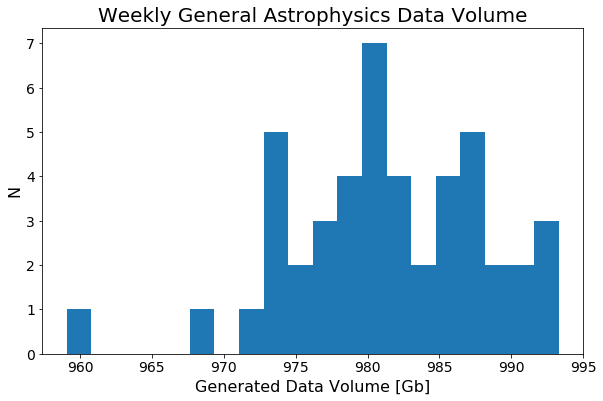

In [249]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Generated Data Volume [Gb]', fontsize=16)
plt.title('Weekly General Astrophysics Data Volume', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(general_astro_data_vol, bins=20)

(array([  2.,   7.,   3.,   3.,  10.,   3.,   5.,   5.,   2.,   6.]),
 array([  36.61116557,   54.59772905,   72.58429252,   90.570856  ,
         108.55741948,  126.54398295,  144.53054643,  162.5171099 ,
         180.50367338,  198.49023686,  216.47680033]),
 <a list of 10 Patch objects>)

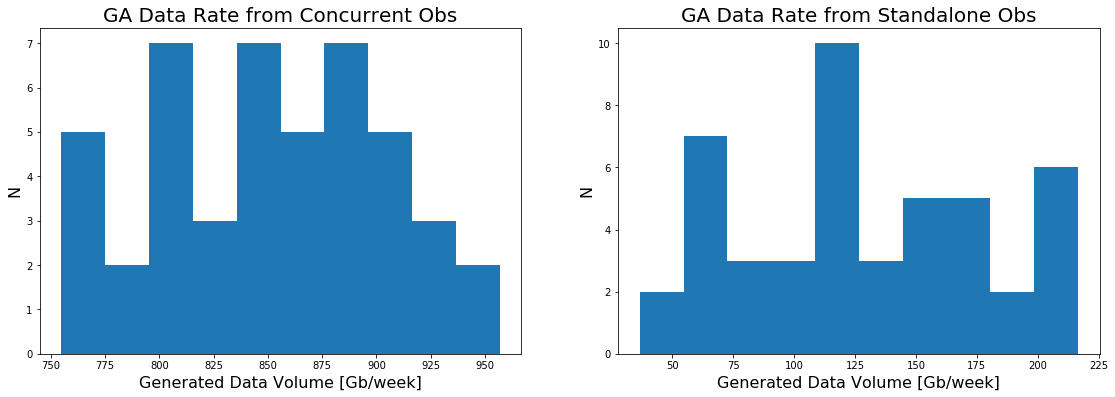

In [250]:
temp1 = [sum(x).value / 1e6 / (52 * 5) for x in all_ga_concur_vol]
temp2 = [sum(x).value / 1e6 / (52 * 5) for x in all_ga_standalone_vol]

plt.figure(figsize=(19,6))
plt.subplot(1,2,1)
plt.xlabel('Generated Data Volume [Gb/week]', fontsize=16)
plt.title('GA Data Rate from Concurrent Obs', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.hist(temp1, bins=10)

plt.subplot(1,2,2)
plt.xlabel('Generated Data Volume [Gb/week]', fontsize=16)
plt.title('GA Data Rate from Standalone Obs', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.hist(temp2, bins=10)

(array([  1.,   0.,   1.,   1.,   7.,   7.,  11.,   6.,   7.,   5.]),
 array([ 959.08838978,  962.5101703 ,  965.93195081,  969.35373132,
         972.77551183,  976.19729235,  979.61907286,  983.04085337,
         986.46263388,  989.8844144 ,  993.30619491]),
 <a list of 10 Patch objects>)

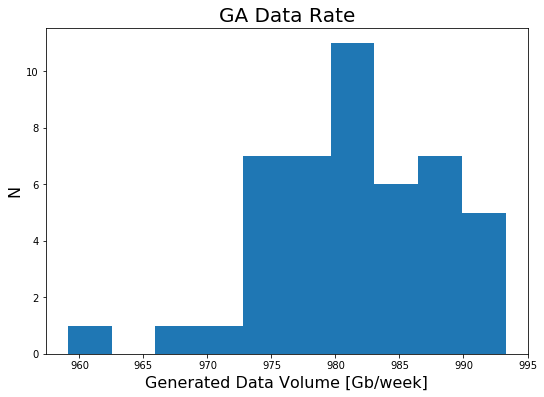

In [251]:
temp1 = [sum(x).value / 1e6 / (52 * 5) for x in all_ga_vol]

plt.figure(figsize=(19,6))
plt.subplot(1,2,1)
plt.xlabel('Generated Data Volume [Gb/week]', fontsize=16)
plt.title('GA Data Rate', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.hist(temp1, bins=10)

In [252]:
[np.mean(temp1), np.std(temp1)]

[981.28598028327008, 6.8278297848876379]

In [253]:
exoscience_data_vol = [sum(x).value / (52 * 5) for x in all_exo_vol]

(array([ 1.,  0.,  1.,  1.,  1.,  0.,  2.,  1.,  4.,  4.,  9.,  5.,  2.,
         3.,  1.,  3.,  2.,  2.,  0.,  4.]),
 array([ 161.69339416,  163.97609538,  166.2587966 ,  168.54149782,
         170.82419904,  173.10690026,  175.38960148,  177.6723027 ,
         179.95500392,  182.23770514,  184.52040636,  186.80310758,
         189.0858088 ,  191.36851002,  193.65121124,  195.93391246,
         198.21661368,  200.4993149 ,  202.78201612,  205.06471734,
         207.34741856]),
 <a list of 20 Patch objects>)

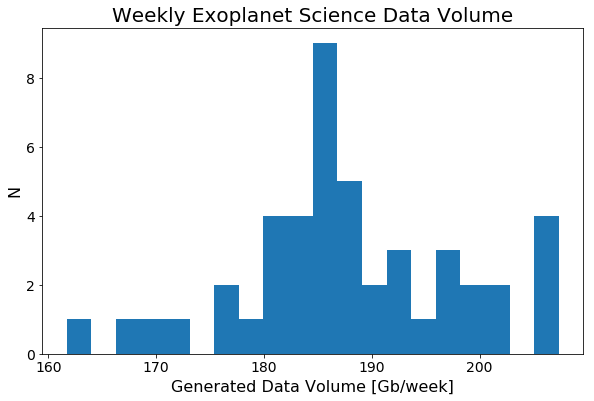

In [254]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Generated Data Volume [Gb/week]', fontsize=16)
plt.title('Weekly Exoplanet Science Data Volume', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(exoscience_data_vol, bins=20)

In [255]:
[np.mean(exoscience_data_vol), np.std(exoscience_data_vol)]

[187.89265781434833, 10.186134575795409]

In [256]:
14.57  + 10.635738467122732

25.205738467122732

## Number of Observations

### Exoplanet Science

#### Detection

(array([ 3.,  3.,  6.,  7.,  4.,  5.,  6.,  3.,  2.,  7.]),
 array([ 178. ,  182.2,  186.4,  190.6,  194.8,  199. ,  203.2,  207.4,
         211.6,  215.8,  220. ]),
 <a list of 10 Patch objects>)

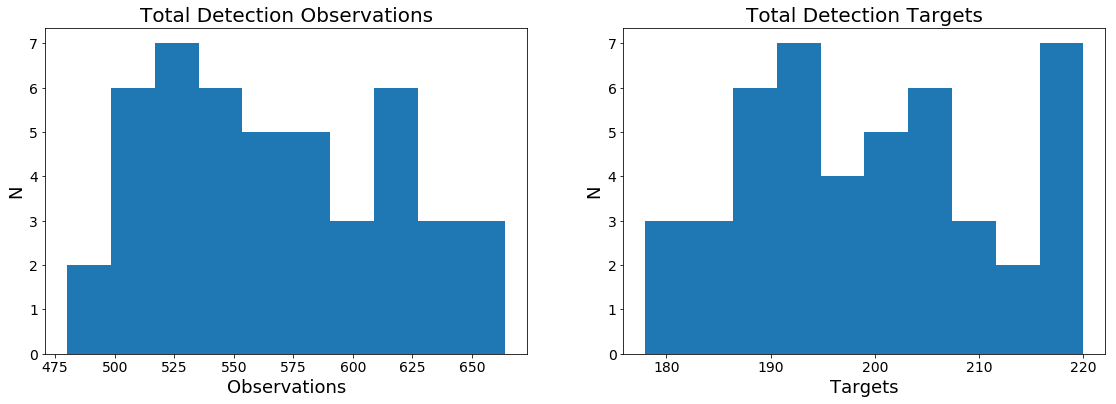

In [257]:
temp1 = [len(x) for x in all_det_star_ind]
temp2 = [len(list(set(x))) for x in all_det_star_ind]

plt.figure(figsize=(19,6))
plt.subplot(1,2,1)
plt.xlabel('Observations', fontsize=18)
plt.title('Total Detection Observations', fontsize=20)
plt.ylabel('N', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp1, bins=10)

plt.subplot(1,2,2)
plt.xlabel('Targets', fontsize=18)
plt.title('Total Detection Targets', fontsize=20)
plt.ylabel('N', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp2, bins=10)

In [258]:
print [np.mean(temp1), np.std(temp1)]
print [np.mean(temp2), np.std(temp2)]

[568.28260869565213, 47.834253255371877]
[199.52173913043478, 11.815132394398484]


#### Characterization

(array([  2.,   5.,   4.,  11.,   6.,   6.,   4.,   4.,   3.,   1.]),
 array([ 33. ,  33.9,  34.8,  35.7,  36.6,  37.5,  38.4,  39.3,  40.2,
         41.1,  42. ]),
 <a list of 10 Patch objects>)

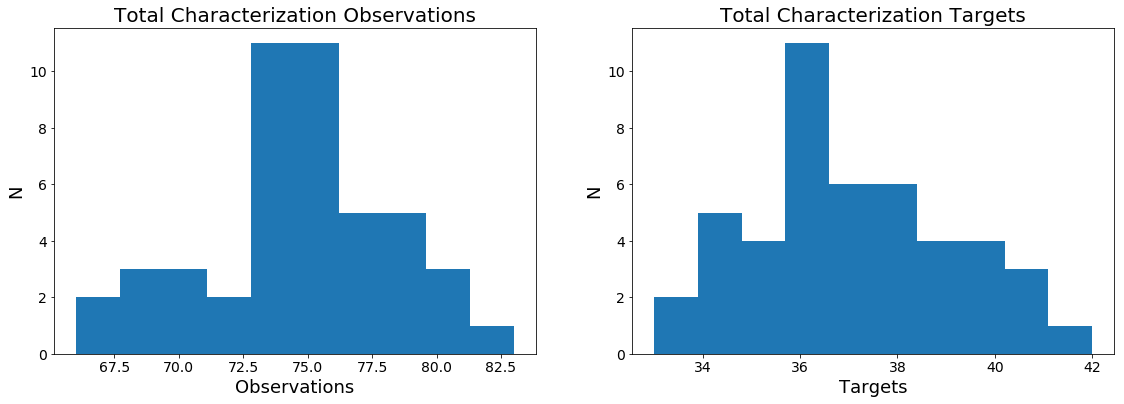

In [259]:
temp1 = [len(x) for x in all_char_star_ind]
temp2 = [len(list(set(x))) for x in all_char_star_ind]

plt.figure(figsize=(19,6))
plt.subplot(1,2,1)
plt.xlabel('Observations', fontsize=18)
plt.title('Total Characterization Observations', fontsize=20)
plt.ylabel('N', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp1, bins=10)

plt.subplot(1,2,2)
plt.xlabel('Targets', fontsize=18)
plt.title('Total Characterization Targets', fontsize=20)
plt.ylabel('N', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp2, bins=10)

In [260]:
print [np.mean(temp1), np.std(temp1)]
print [np.mean(temp2), np.std(temp2)]

[74.673913043478265, 3.6597359599821391]
[37.021739130434781, 2.2601378414561029]


## Maximum Observational Efficiency

In [261]:
temp = [[i.value for i in x] for x in all_ga_standalone_obs_dur]

total_obs_time = [sum(all_det_obs_dur[i]) + sum(all_char_obs_dur[i]) + sum(temp[i])  for i in range(len(all_det_obs_dur))]
sec_in_year = 3600 * 24 * 365

mlife_sec = mission_life.value * sec_in_year

obs_eff = [obs_dur / mlife_sec for obs_dur in total_obs_time]

(array([ 1.,  1.,  1.,  3.,  1.,  1.,  7.,  6.,  7.,  2.,  5.,  3.,  3.,
         3.,  2.]),
 array([ 0.90225303,  0.90367806,  0.90510309,  0.90652812,  0.90795315,
         0.90937818,  0.91080321,  0.91222824,  0.91365327,  0.91507829,
         0.91650332,  0.91792835,  0.91935338,  0.92077841,  0.92220344,
         0.92362847]),
 <a list of 15 Patch objects>)

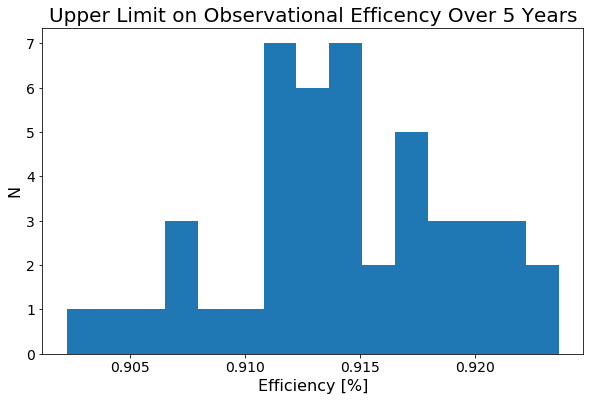

In [262]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Efficiency [%]', fontsize=16)
plt.title('Upper Limit on Observational Efficency Over 5 Years', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(obs_eff, bins=15)

## Average Exo Observing Times

(array([ 436.,  231.,  246.,  169.,   95.,  129.,  133.,  116.,   86.,
          70.,   59.,   84.,   55.,   58.,   67.,   57.,   56.,   59.,
          56.,   50.,   57.,   39.,   39.,   43.,   39.,   22.,   36.,
          35.,   26.,   30.,   29.,   23.,   18.,   16.,   19.,   19.,
          16.,   12.,   24.,   35.,   12.,   14.,   15.,   14.,   11.,
          12.,   17.,   15.,   21.,    8.,   16.,   19.,    7.,   15.,
           9.,   14.,   12.,   15.,   12.,   18.,   15.,    9.,   15.,
          10.,    8.,    7.,    8.,   11.,   12.,    5.,    5.,    6.,
           6.,   10.,    4.,    4.,    1.,    8.,    6.,    5.,    7.,
           6.,    6.,    9.,    9.,   12.,    7.,    6.,    4.,    6.,
           6.,   10.,    3.,    5.,    7.,    1.,    3.,    0.,    0.,    8.]),
 array([    0.        ,    14.38661476,    28.77322951,    43.15984427,
           57.54645903,    71.93307379,    86.31968854,   100.7063033 ,
          115.09291806,   129.47953281,   143.86614757,   158.2527

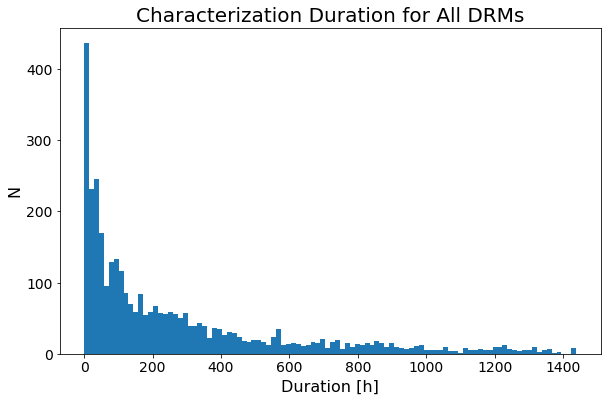

In [263]:
temp1 = [y / 3600. for x in all_char_obs_dur for y in x]

plt.figure(figsize=(9.7,6))
plt.xlabel('Duration [h]', fontsize=16)
plt.title('Characterization Duration for All DRMs', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp1, bins=100)

(array([  9.58900000e+03,   4.20700000e+03,   2.96000000e+03,
          1.65800000e+03,   1.16200000e+03,   7.71000000e+02,
          7.44000000e+02,   3.44000000e+02,   1.39000000e+02,
          3.01000000e+02,   2.77000000e+02,   3.00000000e+02,
          1.14000000e+02,   2.27000000e+02,   2.26000000e+02,
          1.38000000e+02,   1.35000000e+02,   1.15000000e+02,
          9.00000000e+01,   1.00000000e+02,   1.45000000e+02,
          1.31000000e+02,   1.06000000e+02,   1.06000000e+02,
          6.70000000e+01,   1.09000000e+02,   1.54000000e+02,
          9.50000000e+01,   7.00000000e+01,   7.10000000e+01,
          2.40000000e+01,   5.10000000e+01,   8.20000000e+01,
          6.50000000e+01,   6.10000000e+01,   2.50000000e+01,
          4.90000000e+01,   2.20000000e+01,   3.50000000e+01,
          3.60000000e+01,   1.10000000e+02,   5.00000000e+01,
          3.40000000e+01,   3.50000000e+01,   5.80000000e+01,
          2.30000000e+01,   4.80000000e+01,   3.10000000e+01,
        

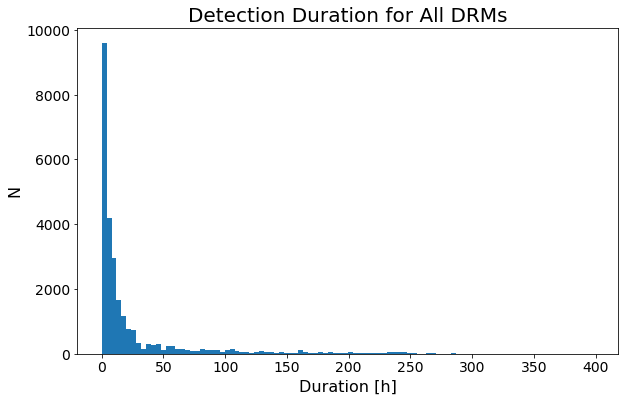

In [264]:
temp1 = [y / 3600. for x in all_det_obs_dur for y in x]

plt.figure(figsize=(9.7,6))
plt.xlabel('Duration [h]', fontsize=16)
plt.title('Detection Duration for All DRMs', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp1, bins=100)

In [265]:
[np.mean(temp1), np.std(temp1)]

[25.025801924846636, 46.74860811638996]

(array([  2.25000000e+02,   2.07200000e+03,   5.02000000e+02,
          2.38000000e+02,   1.49000000e+02,   9.60000000e+01,
          8.10000000e+01,   6.40000000e+01,   6.80000000e+01,
          6.90000000e+01,   6.70000000e+01,   5.90000000e+01,
          4.90000000e+01,   4.80000000e+01,   4.90000000e+01,
          4.70000000e+01,   4.60000000e+01,   4.80000000e+01,
          4.90000000e+01,   3.20000000e+01,   2.90000000e+01,
          1.70000000e+01,   1.70000000e+01,   1.30000000e+01,
          6.00000000e+00,   1.10000000e+01,   6.00000000e+00,
          2.00000000e+00,   1.00000000e+01,   7.00000000e+00,
          3.00000000e+00,   5.00000000e+00,   1.10000000e+01,
          3.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
        

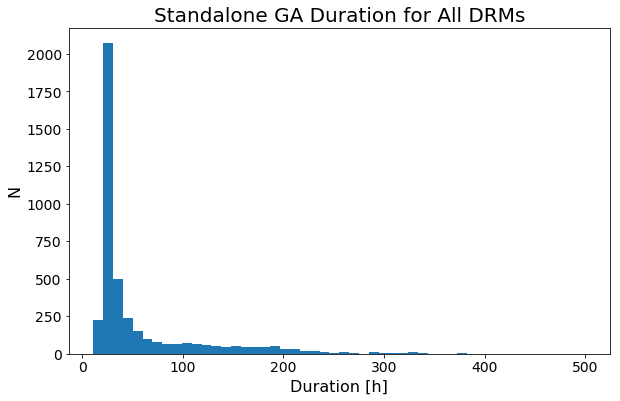

In [266]:
temp1 = [y.value / 3600. for x in all_ga_standalone_obs_dur for y in x]

plt.figure(figsize=(9.7,6))
plt.xlabel('Duration [h]', fontsize=16)
plt.title('Standalone GA Duration for All DRMs', fontsize=20)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp1, bins=50)

In [267]:
np.mean(temp1)

57.477471306063826

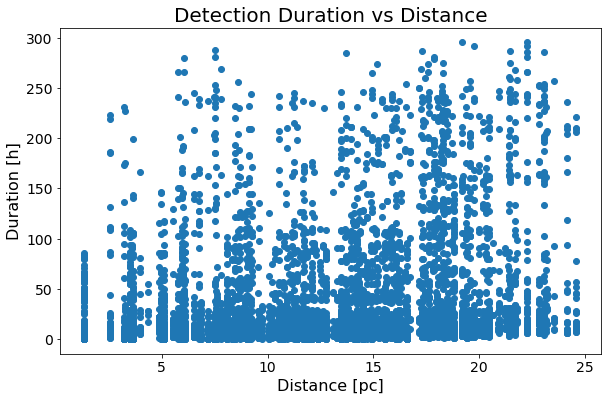

In [268]:
plt.figure(figsize=(9.7,6))
plt.ylabel('Duration [h]', fontsize=16)
plt.title('Detection Duration vs Distance', fontsize=20)
plt.xlabel('Distance [pc]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(asdf[1], asdf[0])

In [274]:
temp1 = [sum(x) for x in all_det_obs_dur]
temp2 = [sum(x) for x in all_char_obs_dur]
temp3 = [(temp1[i] + temp2[i])/3600 for i in range(len(temp1))]
temp4 = [(sum(x).value)/3600 for x in all_ga_obs_dur]

temp5 = [temp4[i] / temp3[i] for i in range(len(temp3))]

temp6 = [x / (5 * 365 * 24) for x  in temp3]
temp7 = [x / (5 * 365 * 24) for x  in temp4]

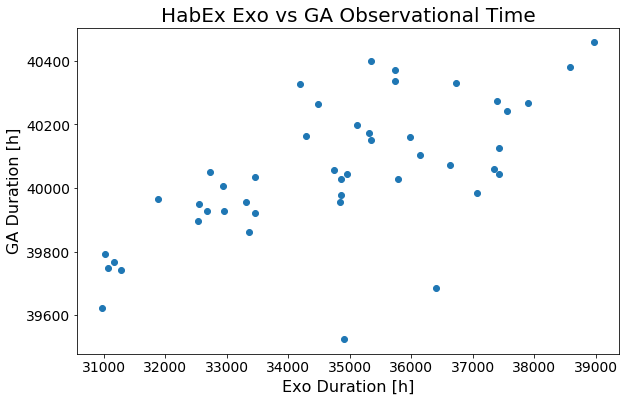

In [275]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Exo Duration [h]', fontsize=16)
plt.title('HabEx Exo vs GA Observational Time', fontsize=20)
plt.ylabel('GA Duration [h]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(temp3, temp4)

(array([ 2.,  1.,  4.,  2.,  3.,  1.,  2.,  4.,  7.,  1.,  2.,  1.,  3.,
         1.,  3.,  3.,  0.,  1.,  1.,  4.]),
 array([ 1.03807446,  1.05031559,  1.06255672,  1.07479785,  1.08703898,
         1.09928011,  1.11152124,  1.12376237,  1.1360035 ,  1.14824463,
         1.16048576,  1.17272688,  1.18496801,  1.19720914,  1.20945027,
         1.2216914 ,  1.23393253,  1.24617366,  1.25841479,  1.27065592,
         1.28289705]),
 <a list of 20 Patch objects>)

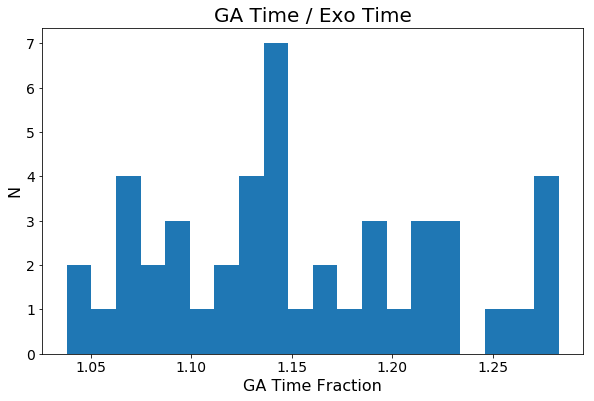

In [271]:
plt.figure(figsize=(9.7,6))
plt.title('GA Time / Exo Time', fontsize=20)
plt.xlabel('GA Time Fraction', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(temp5, bins=20)

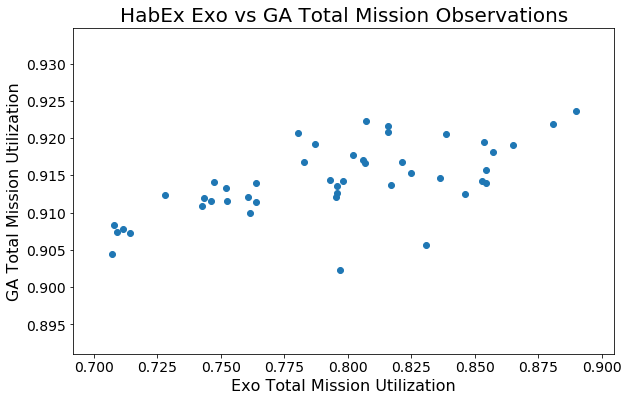

In [272]:
plt.figure(figsize=(9.7,6))
plt.xlabel('Exo Total Mission Utilization', fontsize=16)
plt.title('HabEx Exo vs GA Total Mission Observations', fontsize=20)
plt.ylabel('GA Total Mission Utilization', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(temp6, temp7)